# Amplitude damping channel

In [51]:
from sympy import I, sqrt, symbols, exp, cos, sin, Symbol, Add, Matrix
from sympy.physics.quantum import TensorProduct as ox

theta, psi = symbols(r"\theta, \phi", real=True)
p = Symbol(r"p", positive=True, real=True)

dpsi = Matrix([0, cos(theta), exp(I * psi) * sin(theta), 0])

M_0 = Matrix([[1, 0], [0, sqrt(1-p)]])
M_1 = Matrix([[0, sqrt(p)], [0, 0]])

rho_ab = Add(*[ox(m_u, m_v) * (dpsi * dpsi.H) * ox(m_u.H, m_v.H) for m_u in [M_0, M_1] for m_v in [M_0, M_1]])

rho_ab

Matrix([
[p*sin(\theta)**2 + p*cos(\theta)**2,                                                                      0,                                                                       0, 0],
[                                  0,                      sqrt(1 - p)*cos(\theta)**2*conjugate(sqrt(1 - p)), sqrt(1 - p)*exp(-I*\phi)*sin(\theta)*cos(\theta)*conjugate(sqrt(1 - p)), 0],
[                                  0, sqrt(1 - p)*exp(I*\phi)*sin(\theta)*cos(\theta)*conjugate(sqrt(1 - p)),                       sqrt(1 - p)*sin(\theta)**2*conjugate(sqrt(1 - p)), 0],
[                                  0,                                                                      0,                                                                       0, 0]])

In [28]:
f_psi = (ox(M_0, M_0) + ox(M_1, M_1)) * (dpsi * dpsi.H)

f_psi

Matrix([
[0,                                               0,                                                0, 0],
[0,                      sqrt(1 - p)*cos(\theta)**2, sqrt(1 - p)*exp(-I*\phi)*sin(\theta)*cos(\theta), 0],
[0, sqrt(1 - p)*exp(I*\phi)*sin(\theta)*cos(\theta),                       sqrt(1 - p)*sin(\theta)**2, 0],
[0,                                               0,                                                0, 0]])

In [5]:
def baseTrace(m: Matrix, base: int) -> Matrix:
    if not m.is_square:
        raise Exception("Matrix should be square")
    
    s = int(m.shape[0] / (2 / 2**base))
    d = int(m.shape[0] / 2) - base
    return Matrix([[m[i, j] + m[i + d, j + d] for i in range(0, s, base + 1)] for j in range(0, s, base + 1)])

baseTrace(rho_ab, 0).subs(sqrt(1- p).conjugate(), sqrt(1 - p))

Matrix([
[p*sin(\theta)**2 + p*cos(\theta)**2 + (1 - p)*sin(\theta)**2,                      0],
[                                                           0, (1 - p)*cos(\theta)**2]])

# Experiment

In [13]:
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler as PrimitiveSampler
from qiskit.circuit import Clbit, ClassicalRegister
from qiskit_aer import AerProvider
from qiskit_experiments.library import StateTomography
from qiskit.quantum_info import DensityMatrix, partial_trace, concurrence
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Sampler
from qiskit.visualization import array_to_latex, plot_state_city
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from math import pi, asin, sqrt

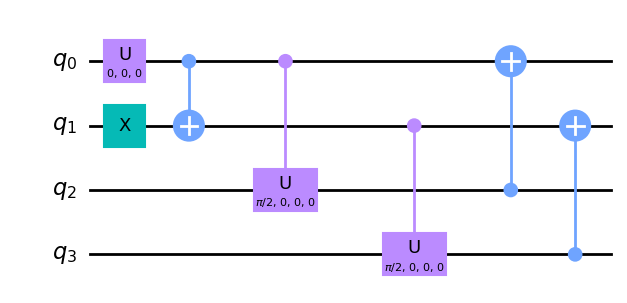

In [2]:
def build_circuit(t: int, p: int) -> QuantumCircuit:
	qc = QuantumCircuit(4)
	qc.u(t, 0, 0, 0)
	qc.x(1)
	qc.cx(0, 1)

	theta = 2 * asin(sqrt(p))
	qc.cu(theta, 0, 0, 0, 0, 2)
	qc.cx(2, 0)

	qc.cu(theta, 0, 0, 0, 1, 3)
	qc.cx(3, 1)
	return qc

qc = build_circuit(0, 0.5)
qc.draw("mpl")

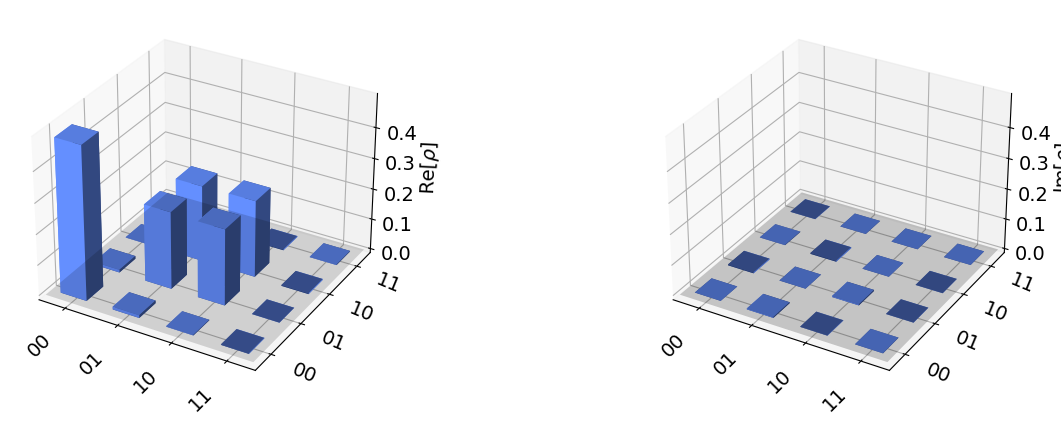

In [3]:
qc = build_circuit(pi/2, 0.5)
backend = AerProvider().get_backend("aer_simulator")
st = StateTomography(qc, measurement_indices=(0,1))
stdata = st.run(backend, shots=10000).block_for_results()
state_result = stdata.analysis_results("state")
# array_to_latex(state_result.value)
plot_state_city(state_result.value)

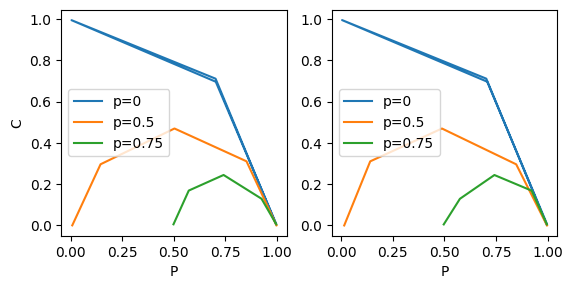

In [4]:
def polarization(density_matrix: DensityMatrix) -> int:
	s1 = 2 * density_matrix.data[0, 0].real - 1
	s2 = 2 * density_matrix.data[0, 1].real
	s3 = - 2 * density_matrix.data[0, 1].imag
	return LA.norm([s1, s2, s3])

backend = AerProvider().get_backend("aer_simulator")
fig, axes = plt.subplots(1, 2)
(ax1, ax2) = axes
i = 0
angles = np.linspace(0, pi, 5)
for p in [0, 0.5, 0.75]:
	pol0_values = []
	con0_values = []
	pol1_values = []
	con1_values = []
	for t in angles:
		qc = build_circuit(t, p)

		st = StateTomography(qc, measurement_indices=(0,1))
		stdata = st.run(backend, shots=10000).block_for_results()
		state_result = stdata.analysis_results("state")
		dm0 = partial_trace(state_result.value, (1,))
		dm1 = partial_trace(state_result.value, (0,))
		pol0 = polarization(dm0)
		pol1 = polarization(dm1)
		pol0_values.append(pol0)
		con0_values.append(concurrence(state_result.value))
		pol1_values.append(pol1)
		con1_values.append(concurrence(state_result.value))

	ax1.plot(pol0_values, con0_values, label=f"p={p}")
	ax2.plot(pol1_values, con1_values, label=f"p={p}")


for a in axes:
	a.set_aspect("equal")
	a.set_xlabel("P")

ax1.set_ylabel("C")
ax1.legend()
ax2.legend()
plt.show()

In [16]:
from typing import Union

def measure_qbit(qc: QuantumCircuit, meas: Union[1, 2, 3], qbit_index: int) -> QuantumCircuit:
	if meas == 2:
		qc.sdg(qbit_index)
		qc.h(qbit_index)
	elif meas == 1:
		qc.h(qbit_index)

	qc.measure(qbit_index, qbit_index)

qc = build_circuit(pi / 5, 0.5)
cl_reg = ClassicalRegister(name="c", bits=[Clbit(), Clbit()])
qc.add_register(cl_reg)

service = QiskitRuntimeService()
with Session(service=service, backend="ibm_nairobi") as session:
	jobs = []
	for i in [1, 2, 3]:
		for j in [1, 2, 3]:
			print(f"Running for S({i}, {j})")
			_qc = qc.copy()
			_qc.name = f"measurement S({i}, {j})"
			measure_qbit(_qc, i, 0)
			measure_qbit(_qc, j, 1)

			job = Sampler().run(_qc)
			jobs.append(job)
			print(job.job_id())

	for j in jobs:
		print(j.result().quasi_dists[0])
		print(f"Finished job {j.job_id()}")

	session.close()

Running for S(1, 1)
cihi9k64c9s1cd0j82cg
Running for S(1, 2)
cihi9kbu5mrpmce3cvjg
Running for S(1, 3)
cihi9kju5mrpmce3cvog
Running for S(2, 1)
cihi9kju5mrpmce3cvt0
Running for S(2, 2)
cihi9kr5n9v6ta19utsg
Running for S(2, 3)
cihi9l7985671v5ojpp0
Running for S(3, 1)
cihi9l3u5mrpmce3d070
Running for S(3, 2)
cihi9lc60l54kvbgp4eg
Running for S(3, 3)
cihi9ln985671v5ojq30


In [1]:
from qiskit.circuit import Clbit, ClassicalRegister

qc = build_circuit(pi / 2, 0)
cl_reg = ClassicalRegister(name="c", bits=[Clbit(), Clbit()])
# qc.add_bits([Clbit(), Clbit()])
qc.add_register(cl_reg)
qc.measure(0, 0)
qc.measure(1, 1)
qc.draw("mpl")

st = StateTomography(qc, measurement_indices=(0,1))
st._meas_circ_basis

# backend = AerProvider().get_backend("aer_simulator")
# job = backend.run(qc, shots=100)

# result = job.result()
# print(result.get_counts())


NameError: name 'build_circuit' is not defined